# Global Terrorist Attacks


# Assignment:
Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group.

Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident. 

In [32]:
import pandas as pd
import pprint
import numpy as np
import warnings
from collections import Counter
from gensim.models import word2vec
from mpl_toolkits.basemap import Basemap
from sklearn.cross_validation import train_test_split , KFold
from sklearn.ensemble import RandomForestClassifier , AdaBoostClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, recall_score,precision_score , auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.semi_supervised import label_propagation
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

# Data set

In [18]:
GTD_Original = pd.read_csv('D_globalterrorismdb_0616dist.csv')
G = pd.read_csv('globalterrorismdb_0616dist.csv')
print (GTD_Original.shape)
GTD_Original.head()

(156772, 50)


,eventid,iyear,imonth,iday,extended,country,country_txt,region,region_txt,latitude,...,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,gname_value,ishostkid,ransom,ransomamt,ransomamtus,ransompaid
0,197000000001,1970,0,0,0,58,Dominican Republic,2,Central America & Caribbean,18.456792,...,0,0,0,0,1767,0.0,0.0,0.0,0.0,0.0
1,197000000002,1970,0,0,0,130,Mexico,1,North America,19.432608,...,0,1,1,1,13,1.0,1.0,800000.0,0.0,0.0
2,197001000001,1970,1,0,0,160,Philippines,5,Southeast Asia,15.478598,...,-9,-9,1,1,3150,0.0,0.0,0.0,0.0,0.0
3,197001000002,1970,1,0,0,78,Greece,8,Western Europe,37.983773,...,-9,-9,1,1,3150,0.0,0.0,0.0,0.0,0.0
4,197001000003,1970,1,0,0,101,Japan,4,East Asia,33.580412,...,-9,-9,1,1,3150,0.0,0.0,0.0,0.0,0.0


# DATA CLEANING

- saved xls file as csv 

- Dropped 96 Features due to textual nature or simply missing too many data points to use as a feature for the classifier, this was a decision made manually in the Excel spreadsheet


In [133]:
# original = set(GTD_Original)
# new = set(GTD)
# difference = original.symmetric_difference(new)
# len(difference)

In [134]:
# filling in Missing values for each column

for i in list(GTD_Original):
    try:
        GTD_Original[i] = [np.nan_to_num(j) for j in list(GTD_Original[i])]
    except:
        pass
    
# Transforming names of Terrorist groups (categorical) into num

le =LabelEncoder()
le.fit(GTD_Original['gname'])
GTD_Original['gname_value'] = le.transform(GTD_Original['gname']) 

# Saving copy of modified csv

GTD_Original.to_csv('D_globalterrorismdb_0616dist.csv', index=False)


# EDA

# Taking a look at where Terrorism Happens

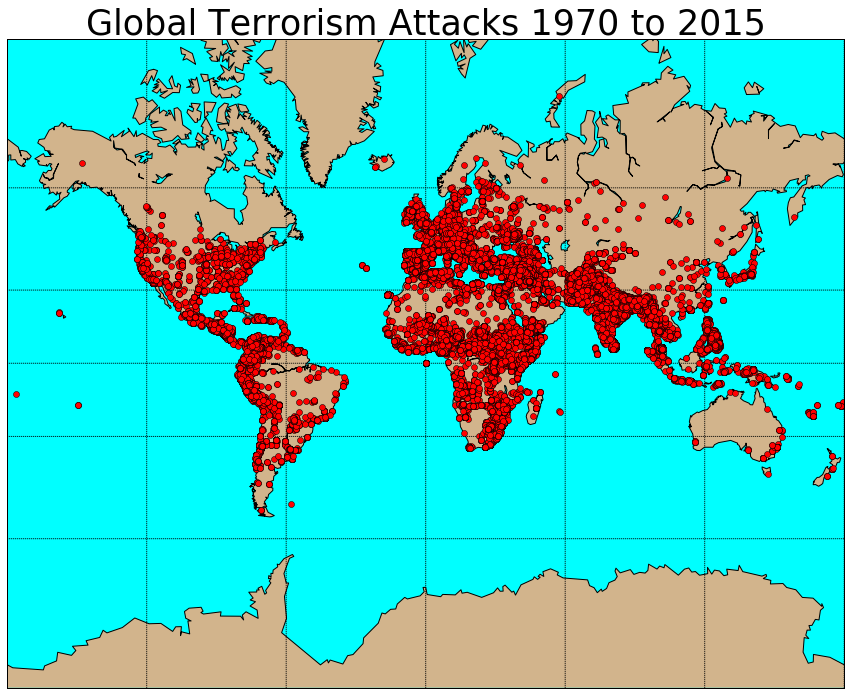

In [110]:
plt.figure(figsize = (15,15))
m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,\
            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')
# Draw the coastlines
m.drawcoastlines()
# Color the continents
m.fillcontinents(color='tan',lake_color='aqua')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,30.))
m.drawmeridians(np.arange(-180.,181.,60.))
# fill in the ocean
m.drawmapboundary(fill_color='aqua')

lons = list(GTD_Original['longitude'])
lats = list(GTD_Original['latitude'])
x,y = m(lons, lats)
m.plot(x, y, 'bo', color='red')

plt.title("Global Terrorism Attacks 1970 to 2015" , size = 35)
plt.show()

# https://peak5390.wordpress.com/2012/12/08/matplotlib-basemap-tutorial-plotting-points-on-a-simple-map/

# http://matplotlib.org/basemap/users/merc.html

# Breakdown by Year

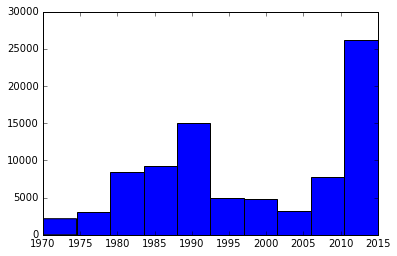

In [33]:
plt.hist(Known['iyear'])
plt.show()

There was a rise in terrorist attacks in the 1990s, but a huge spike in the mid 2000's and beyond 

# Break down by Months

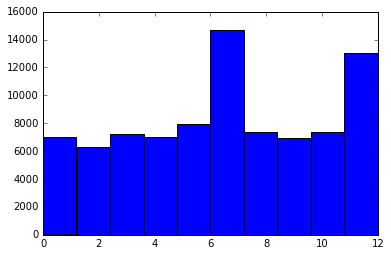

In [34]:
plt.hist(Known['imonth'])
plt.show()

June and December seem to be the most popular months for terrorist activities

In [35]:
weapontype = {
    1: 'Biological',
    2: 'Chemical',
    3: 'Radiological',
    4: 'Nuclear',
    5: 'Firearms',
    6: 'Explosives',
    7: 'Fake Weapons',
    8: 'Incendiary',
    9: 'Melee',
    10: 'Vehicle',
    11: 'Sabotage',
    12: 'Other',
    13: 'Unkown'
}

In [69]:
#Counter(Known['weaptype1'])

# Breakdown by Weapon Type

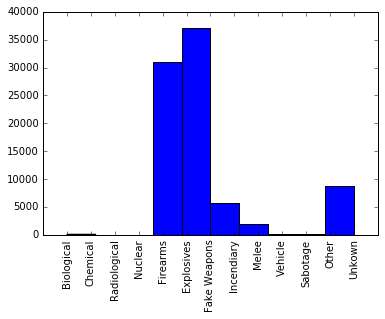

In [37]:
plt.hist(Known['weaptype1'])
x = weapontype.values()
plt.xticks(range(1, len(x)+1),[weapontype[i] for i in range(1, len(x)+1)] , size = 10 , rotation=90 )
plt.show()

5- Firearms and 6-Bombs/explosives seem to be the weapon on choice for Terrorism

# Breakdown by Attack Type

In [64]:
attacktype = ['Assassination',
'Hijacking',
'Kidnapping',
'Barricade Incident',
'Bombing/Explosion',
'Armed Assault',
'Unarmed Assault',
'Facility/Infrastructure Attack',
'Unknown']

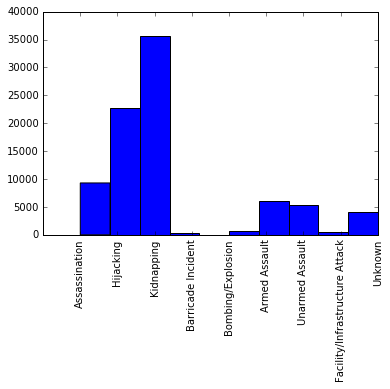

In [66]:
plt.hist(Known['attacktype1']);
plt.xticks(range(1,10),attacktype, rotation = 90);

Hijacking and Kidnapping are the most common forms of terrorism

# Top 10 Regions of Terrorism

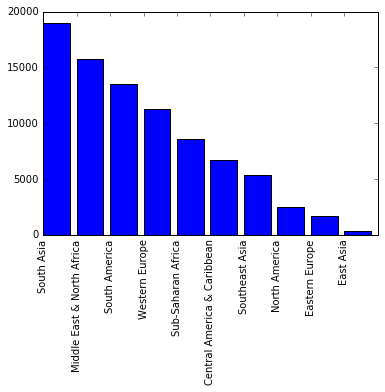

In [38]:
x = list(Counter(Known['region_txt']).most_common(10))
x_ticks = [i[0] for i in x]
values = [i[1] for i in x]
plt.bar(range(len(x)),values)
plt.xticks(range(len(x)), x_ticks, size = 10 , rotation=90)
plt.show()

Majority of Terrorism attacks Happened in South Asia and the Middle East / North Africa

# Number of known groups 

In [39]:
print len(set(Known['gname']))

3289


# Top 10 Countries for Terrorism

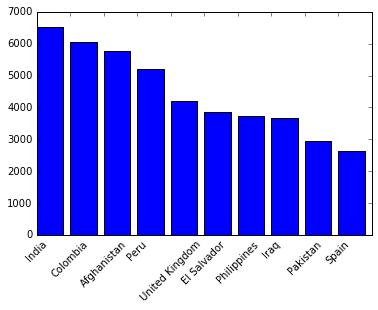

In [40]:
x = list(Counter(Known['country_txt']).most_common(10))
x_ticks = [i[0] for i in x]
values = [i[1] for i in x]
plt.bar(range(len(x)),values)
plt.xticks(range(len(x)), x_ticks, size = 10 , rotation=45)
plt.show()

India and Columbia has had more terror attacks than any other country

# Top 10 Terrorist Groups

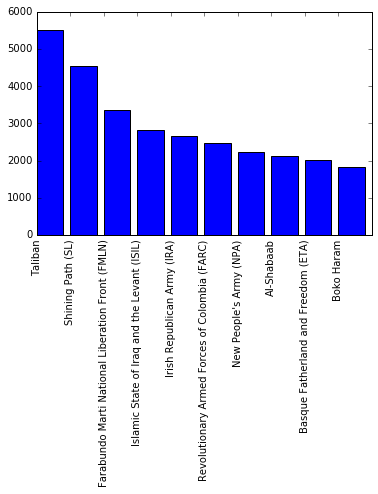

In [41]:
x = list(Counter(Known['gname']).most_common(10))
x_ticks = [i[0] for i in x]
values = [i[1] for i in x]
plt.bar(range(len(x)),values)
plt.xticks(range(len(x)), x_ticks, size = 10 , rotation= 90 )
plt.show()

Tabilan has committed more terrorist activity than other other group

# Some Natural Language Processing

I thought it would be nice to look at the comments for motives and see if we can learn something from it.

In [19]:
# Preparing data for Topic Modeling and Word2Vec

motive =list(i for i in G['motive'] if str(i)==i)

words = []
for i in motive:
    try: 
        words.append(i.decode('utf-8').lower())
    except:
        pass

for i in words:
    with open("motive.txt", "w") as text_file:
        text_file.write(i)

In [20]:
# Topic Modeling to get a sense of what categories are available in the motives

vec=TfidfVectorizer(stop_words='english',analyzer='word')
vec.fit(words)
X_train_counts = vec.fit_transform(words)

vocab = vec.get_feature_names()
nmf = NMF(n_components = 5, random_state = 1)
nmf.fit(X_train_counts)

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print(print_top_words(nmf, vocab, 30))

Topic #0:
unknown sources motive specific noted targeted posited attacks victims speculated state assailants victim note elections source believed occurred 2014 group day informant scheduled officials recent attacked ransom maoists order shabaab
Topic #1:
attack specific motive reported intimidate political sources religious enforcement law area government suspected speculated police posited carried extortion authorities occurred prevent iraqi christians russian military demand disrupt believe party local
Topic #2:
shiite sunni sectarian communities violence larger minority majority trend sources speculated iraq targeted pakistan suspected community mosque neighborhood muslim predominately pattern pilgrims ida qa christian hazara al members speculate victims
Topic #3:
claimed government responsibility islamic stated carried incident campaign forces sources security retaliation destabilize algeria al police state algerian extremists iraq isil suspected military apostate attacks weakenin

# Suggested Topics

Topic 1: positioned attacks/ransom

Topic 2: Political intimidation

Topic 3: Islamic vs Christians

Topic 4: Retaliation

Topic 5: parliamentary/Elections Extortion


# Featured Words

In [31]:
vectorizer = TfidfVectorizer(stop_words='english',analyzer='word')
X = vectorizer.fit_transform(words,)
indices = np.argsort(vectorizer.idf_)
features = vectorizer.get_feature_names()
top_n = 20
top_features = [features[i] for i in indices[:top_n]] 

print pprint.pprint(top_features)

[u'unknown',
 u'motive',
 u'specific',
 u'attack',
 u'sources',
 u'claimed',
 u'government',
 u'targeted',
 u'violence',
 u'incident',
 u'responsibility',
 u'noted',
 u'stated',
 u'carried',
 u'speculated',
 u'larger',
 u'trend',
 u'iraq',
 u'police',
 u'suspected']
None


# Note:

Looks as if largely, the motivations were unknown, if they were, it was specific and violent towards the government with claims to the attack

In [27]:
# Finding similar words used to describe motives

sentences = word2vec.Text8Corpus('motive.txt') 
model = word2vec.Word2Vec(sentences,min_count=1)
model.most_similar('motive')

[(u'spies', 0.12652499973773956),
 (u'however,', 0.09997186064720154),
 (u'victims', 0.08819161355495453),
 (u'posited', 0.07689623534679413),
 (u'al-shabaab', 0.059093937277793884),
 (u'because', 0.03863890469074249),
 (u'specific', 0.03430412709712982),
 (u'is', 0.00021484866738319397),
 (u'believed', -0.02364964410662651),
 (u'sources', -0.025594448670744896)]

# Machine Learning 


In [5]:
Known = GTD_Original[GTD_Original['gname']!='Unknown']  # using only known labels to predict
Unknown = GTD_Original[GTD_Original['gname']=='Unknown']
Known.shape

(84850, 50)

In [ ]:
columns = ['iyear','imonth','iday','extended',
           'country','region','specificity',
           'latitude','longitude','vicinity',
           'crit1','crit2','crit3','doubtterr',
           'multiple','success', 'ishostkid', 
           'ransom','ransomamt','ransomamtus',
           'ransompaid','suicide','attacktype1',
           'targtype1','targsubtype1','natlty1',
           'ingroup','guncertain1','weaptype1',
           'weapsubtype1','nkill','property',
           'propextent','propvalue','INT_LOG',
           'INT_IDEO','INT_MISC','INT_ANY']

In [39]:
X= Known[columns]

y= Known['gname_value']


In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

# Using TSNE to Group and Visualize Terrorists

In [143]:
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
terrorist = tsne.fit_transform(X.as_matrix()[::10])

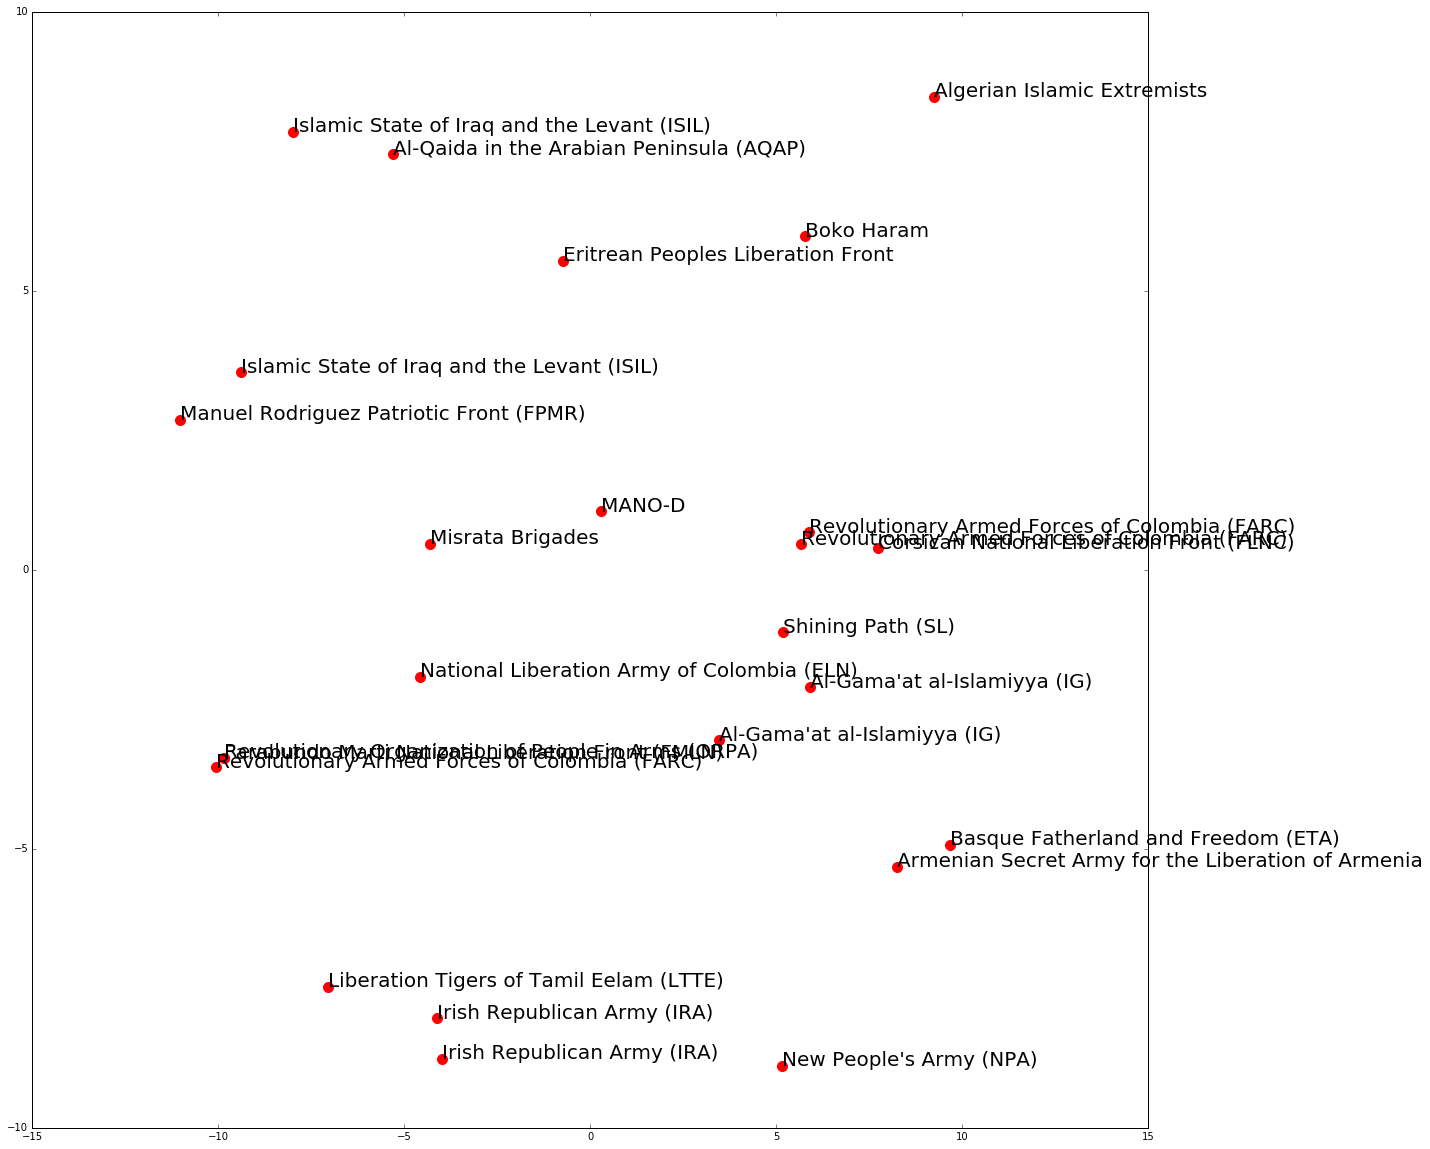

In [192]:
plt.figure(figsize=(20,20))
#plt.scatter(terrorist[:, 0], terrorist[:, 1], color = 'blue')
for label, x, y in zip(list(Known['gname'])[::10][::345], terrorist[:, 0][::345], 
                       terrorist[:, 1][::345]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points' , size = 20)
plt.scatter(terrorist[:, 0][::345], terrorist[:, 1][::345] , color = 'red', s = 100)
plt.show()

# Note:
- Islamic Terrorists tend to group towards the top, where Latin American groups are in the center and European and Asian groups are in the bottom 

# Predictions:

In [11]:
# One vs Rest Method and a Random Forest

# Also, using the Power of Amazon GPUS for faster run time

clf = OneVsRestClassifier(RandomForestClassifier())  
clf.fit(X_train,y_train)
clf.score(X_test,y_test)

0.93489841135152973

In [12]:
def print_metrics(y_actual, y_predict):
    """Prints multiple metrics"""
    print "Accuracy:", (y_predict == y_actual).mean()
    print "Precision:", precision_score(y_actual, y_predict)
    print "Recall:", recall_score(y_actual, y_predict)
    print "F1-score:", f1_score(y_actual, y_predict)


print_metrics(y_test, clf.predict(X_test))

Accuracy: 0.934898411352
Precision: 0.918050456351
Recall: 0.934898411352
F1-score: 0.922780974969


In [63]:
kf = KFold(Known.shape[0], n_folds = 10, shuffle = True)
F1 = []
Acc = []

X_matrix = Known.as_matrix(columns=columns)

y_matrix = Known.as_matrix(columns = ['gname_value'])

for train_index, test_index in kf:
    X_train, X_test = X_matrix [train_index],X_matrix[test_index]
    y_train, y_test = y_matrix[train_index],y_matrix[test_index]
    c= OneVsRestClassifier(RandomForestClassifier()).fit(X_train,y_train)
    predict =c.predict(X_test)
    Acc.append(c.score(X_test,y_test))
    F1.append(f1_score(y_test,predict))

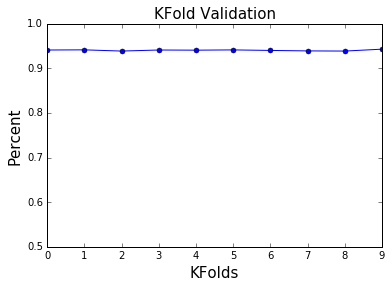

In [64]:
plt.plot(range(len(Acc)),Acc , marker = 'o', markersize = 5)
plt.xlabel("KFolds" , size = 15)
plt.ylabel("Percent", size = 15)
plt.ylim(0.5,1)
plt.title("KFold Validation", size = 15)
plt.show()

# Note:
- Data prediction is consistent even with the splitting of data

# Using Known Terroist Groups to predict Unknown Groups

In [141]:
# create a lookup table with label and group name

d = {}
    
for i,j in zip(Known['gname'],Known['gname_value']):
        d[j] = i

#using the whole known dataset to predict unknowns

clf = OneVsRestClassifier(RandomForestClassifier())  
clf.fit(X,y)

Unknown_matrix = Unknown.as_matrix(columns=columns)

predictions = clf.predict(Unknown_matrix)

In [142]:
Unknown['Predicted Class'] = [d[category] for category in predictions]  # save information

# Sample of the Predictions

In [144]:
# save the data for later

# Known.to_csv('Known_globalterrorism.csv', index=False)
Unknown.to_csv('UnKnown_globalterrorism.csv', index=False)

In [212]:
U = pd.read_csv('UnKnown_globalterrorism.csv')
U[['eventid','iyear', 'country_txt', 'region_txt', 'Predicted Class']][::2001]

,eventid,iyear,country_txt,region_txt,Predicted Class
0,197001000001,1970,Philippines,Southeast Asia,Abu Sayyaf Group (ASG)
2001,197901190002,1979,Italy,Western Europe,Armed Revolutionary Nuclei (NAR)
4002,198101150006,1981,India,South Asia,National Socialist Council of Nagaland
6003,198209050001,1982,Peru,South America,Terrorists
8004,198502060013,1985,Guatemala,Central America & Caribbean,Democratic Revolutionary Alliance (ARDE)
10005,198711110005,1987,Lebanon,Middle East & North Africa,Islamist Extremists
12006,198910300017,1989,Peru,South America,Narco-Terrorists
14007,199105230005,1991,Turkey,Middle East & North Africa,Dev Sol
16008,199209050009,1992,Ecuador,South America,Death Squad
18009,199411300005,1994,Somalia,Sub-Saharan Africa,African National Congress (South Africa)


# Use Case:    
- In an event, if the terrorist group is unknown, the model can give you a prediction of who **might** be responsible for the attack, based on known terrorist groups and patterns.  

# Future Work:
- Featuring engineering to find out what the best features are for predictions
- boosted models
- semi-supervised learning for unlabeled data
- Grid Search for optimal Parameters
- More exploration for text data